In [1]:
using DataFrames, CSV, DelimitedFiles, Statistics

CODE_ROOT = pwd()

JULIA_DATA_ROOT = CODE_ROOT * "/output"

FORTRAN_DATA_ROOT = CODE_ROOT * "/data/new-fortran-timing/"

include(CODE_ROOT * "/visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [14]:
# the maximum number of processes each mesh resolution was parallelized with
# each process should have at least 4 cells (nCellsX^2)/maxprocs[nCellsX] >= 4
# julia and fortran run with different limits due to slightly different mesh partitionings
maxprocs = Dict{Int64, Int64}(
    16 => 64,
    32 => 128,
    64 => 512,
    128 => 2048,
    256 => 4096,
    512 => 4096,
    )

ftprocs = Dict{Int64, Vector{Tuple{Int64, Int64}}}(
    16 => [(1, 64)],
    32 => [(1,64)],
    64 => [(1,64)],
    128 => [(64, 4096), (1, 256)],
    256 => [(64, 4096), (1, 256)],
    512 => [(64, 4096), (1, 256)],
    )
;

In [3]:
function latestfile(dir, filterfunc)
    fnames = filter(filterfunc, readdir(dir, join=true))
    @assert length(fnames) > 0 "no file in $dir matching pattern!"
    return fnames[end]
end

latestfile (generic function with 1 method)

In [40]:
function juliatimes(nCellsX, jprocs=4096)
    # read julia data from file
    fname = latestfile(JULIA_DATA_ROOT * "/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
    df = DataFrame(CSV.File(fname))
    
    # get the simulation time and communication time columns, excluding the first one (this is usually slower from warm-up)
    simkeys = filter(col->startswith(col,"sim_time"), names(df))[2:end]
    mpikeys = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
    
    simtimes = Array(df[:,simkeys])
    mpitimes = Array(df[:,mpikeys])
    runtimes = simtimes + mpitimes
    
    juliarunmeans = dropdims( mean(runtimes, dims=2), dims=2)
    juliampimeans = dropdims( mean(mpitimes, dims=2), dims=2)
    
    juliarunminmax = permutedims(hcat(minimum(runtimes, dims=2), maximum(runtimes, dims=2)), (2,1))
    juliampiminmax = permutedims(hcat(minimum(mpitimes, dims=2), maximum(mpitimes, dims=2)), (2,1))
    
    return juliarunmeans, juliampimeans, df.procs, juliarunminmax, juliampiminmax, fname
end
function fortrantimes(nCellsX, fprocs=[(64, 4096), (1, 256)], plane=64)
    fortrandir = FORTRAN_DATA_ROOT * "resolution$(nCellsX)x$(nCellsX)"
    
    # read fortran data from files
    runtimes = Dict{Int64, Float64}()
    mpitimes = Dict{Int64, Float64}()
    runminmax = Dict{Int64, Tuple{Float64, Float64}}()
    mpiminmax = Dict{Int64, Tuple{Float64, Float64}}()
    for (minprocs, maxprocs) in fprocs
        fortranfnamerun = latestfile(fortrandir,
            x -> occursin("$(maxprocs)pmax", x) && occursin("$(minprocs)pmin", x) && occursin("$(plane)plane", x) && occursin("runtime", x))
        fortranfnamempi = latestfile(fortrandir,
            x -> occursin("$(maxprocs)pmax", x) && occursin("$(minprocs)pmin", x) && occursin("$(plane)plane", x) && occursin("halotime", x))
        fortranruntiming = readdlm(fortranfnamerun, skipstart=8)
        fortranmpitiming = readdlm(fortranfnamempi, skipstart=8)
        for (i, p) in enumerate(fortranruntiming[:,1])
            runtimes[p] = fortranruntiming[i,end]
            mpitimes[p] = fortranmpitiming[i,end]
            runminmax[p] = (minimum(fortranruntiming[i,2:end]), maximum(fortranruntiming[i,2:end]))
            mpiminmax[p] = (minimum(fortranmpitiming[i,2:end]), maximum(fortranmpitiming[i,2:end]))
        end
    end
    procs = sort(collect(keys(runtimes)))
    fruntimes = collect([runtimes[p] for p in procs])
    fmpitimes = collect([mpitimes[p] for p in procs])
    fruntimes += fmpitimes
    frunminmax = collect([runminmax[p][k] for k in 1:2, p in procs])
    fmpiminmax = collect([mpiminmax[p][k] for k in 1:2, p in procs])
    frunminmax += fmpiminmax
    return fruntimes, fmpitimes, procs, frunminmax, fmpiminmax, fortrandir
end
function juliafortrantimesplits(nCellsX, jprocs=4096, fprocs=4096)
    juliarunmean, juliampimean, juliaprocs, juliarunminmax, juliampiminmax, juliafname = juliatimes(nCellsX, jprocs)
    fortranrunmean, fortranmpimean, fortranprocs, fortranrunminmax, fortranmpiminmax, fortranfnamerun = fortrantimes(nCellsX, fprocs)
    return juliarunmean, juliampimean, juliaprocs, fortranrunmean, fortranmpimean, fortranprocs, juliafname, fortranfnamerun, juliarunminmax, juliampiminmax, fortranrunminmax, fortranmpiminmax
end

juliafortrantimesplits (generic function with 3 methods)

In [9]:
linewidth = 1
linestyle = "-"
markersize = 10
tickfontsize = 15
labelfontsize = 22.5
titlefontsize = 25
blue = "blue"
red = "red"

"red"

In [10]:
function strongscalingplot(juliameans, juliaprocs, fortranmeans, fortranprocs, nCellsX, juliaerr=0, fortranerr=0; perfect=true)

    perfectjulia = juliameans[1] * juliaprocs[1] ./ juliaprocs
    
    fig, ax = plt.subplots(figsize=(9,9))
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.errorbar(juliaprocs, juliameans, yerr=juliaerr, label="Julia", linewidth=linewidth,linestyle="-",
                capsize=5, color=red,marker="s",markersize=markersize)
    ax.errorbar(fortranprocs, fortranmeans, yerr=fortranerr, label="Fortran", linewidth=linewidth,
                capsize=5, linestyle="--", color=blue,marker="D",markersize=markersize)
    if perfect
        ax.plot(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)
    end

    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
    ax.set_ylabel("Simulation time (s)", fontsize=labelfontsize, labelpad=10)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=titlefontsize, fontweight="bold", y=1.02)
    ax.legend(loc="upper right", fontsize=labelfontsize-2.5)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot (generic function with 3 methods)

In [11]:
savefigs=false

false

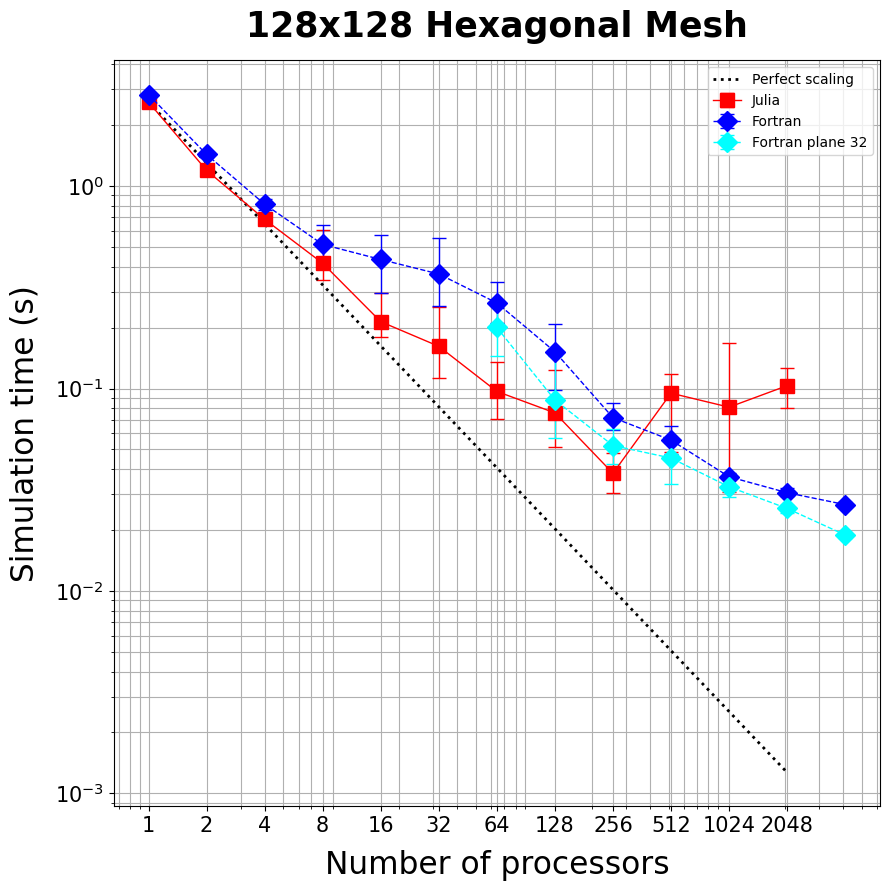

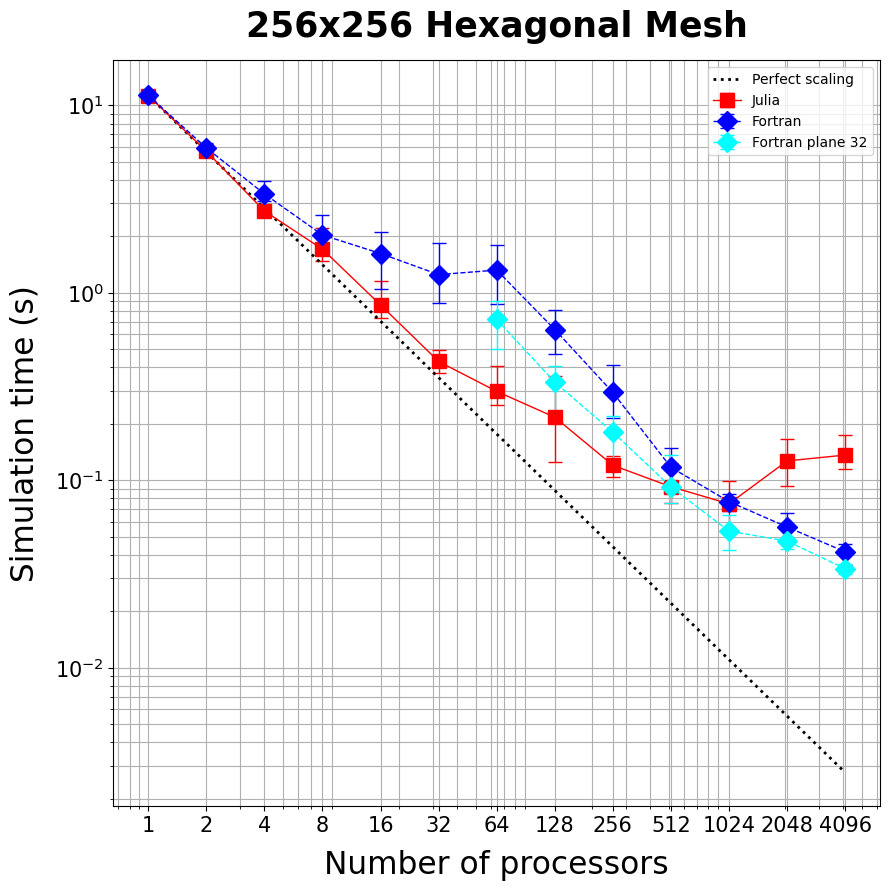

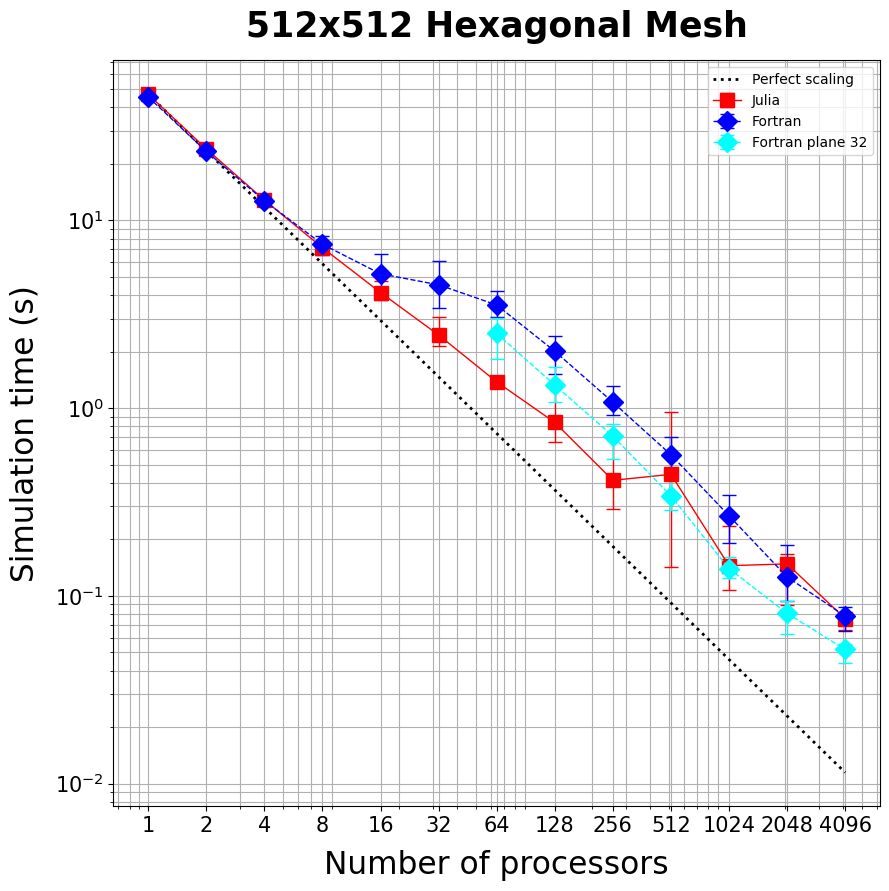

In [48]:
# for plane in [32, 64]
for nCellsX in [128, 256, 512]
    jrun, jmpi, jprocs, jrunminmax, jmpiminmax, jfile = juliatimes(nCellsX, maxprocs[nCellsX])
    frun32, fmpi32, fprocs32, frunminmax32, fmpiminmax32, _ = fortrantimes(nCellsX, [(64, 4096)], 32)
    frun64, fmpi64, fprocs64, frunminmax64, fmpiminmax64, _ = fortrantimes(nCellsX, ftprocs[nCellsX], 64)

    fig, ax = strongscalingplot(jrun, jprocs, frun64, fprocs64, nCellsX,
                        abs.(jrun' .- jrunminmax), abs.(frun64' .- frunminmax64))
    ax.errorbar(fprocs32, frun32, yerr=abs.(frun32' .- frunminmax32), label="Fortran plane 32", linewidth=linewidth,
                capsize=5, linestyle="--", color="cyan", marker="D",markersize=markersize)
    ax.legend()
    # ax.set_title("Plane=$(plane) $(nCellsX)x$(nCellsX) Hexagonal Mesh\nComputation and Communication", fontsize=titlefontsize, fontweight="bold", y=1.02)
end
# end

saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/total_output--kelvinwave--resolution128x128--procs2048--steps10--nvlevels100--2023-06-25T17:31:11.463.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/calc_only_output--kelvinwave--resolution128x128--procs2048--steps10--nvlevels100--2023-06-25T17:31:11.463.txt.pdf
128/procs2048/steps10/nvlevels100/2023-06-25T17:31:11.463.txt
os/MPAS_Ocean_Julia/data/new-fortran-timing/resolution128x128
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/total_output--kelvinwave--resolution256x256--procs4096--steps10--nvlevels100--2023-06-24T08:37:01.346.txt.pdf
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/strong_scaling/calc_only_output--kelvinwave--resolution256x256--procs4096--steps10--nvlevels100--2023-06-24T08:37:01.346.txt.pdf
256/procs4096/steps10/nvlevels100/2023-06-24T08:37:01.346.txt
os/MPAS_Ocean_Julia/data/new-fortran-timing/resolution256x256
save

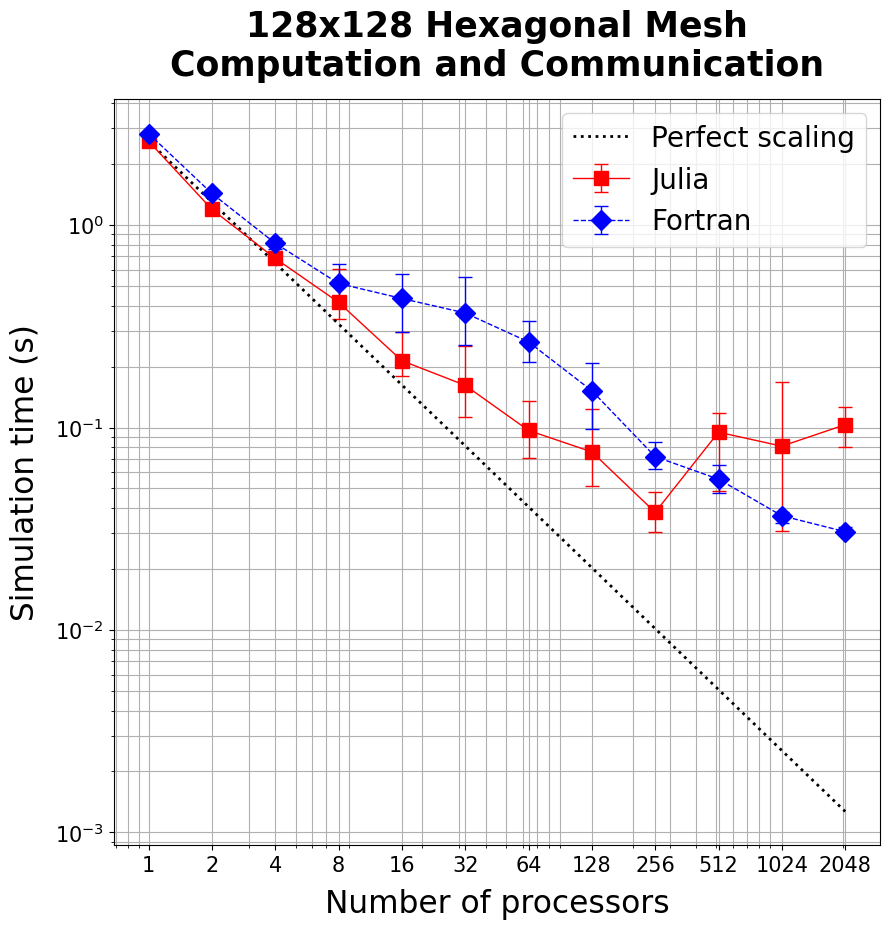

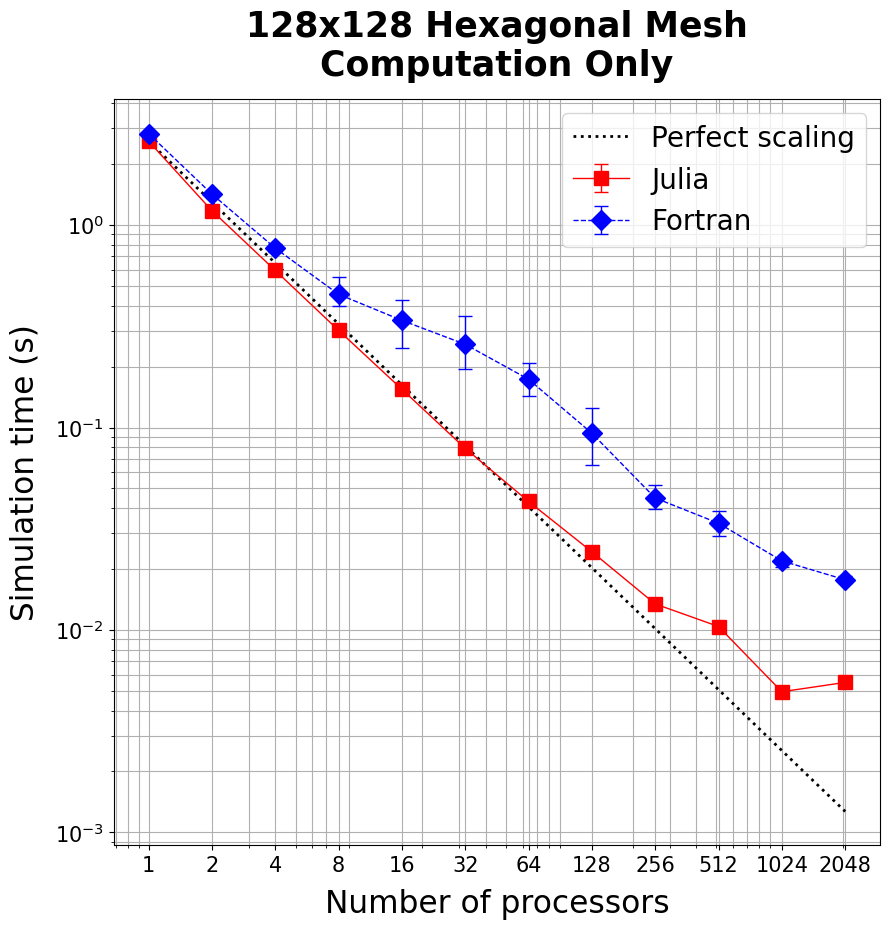

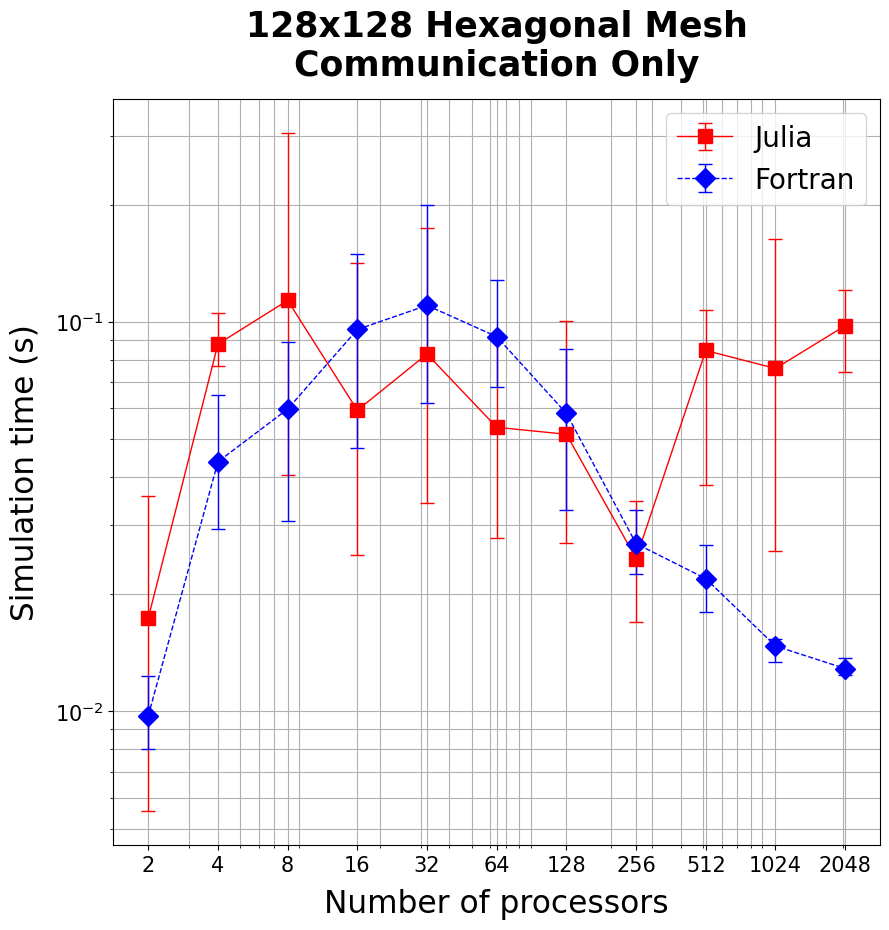

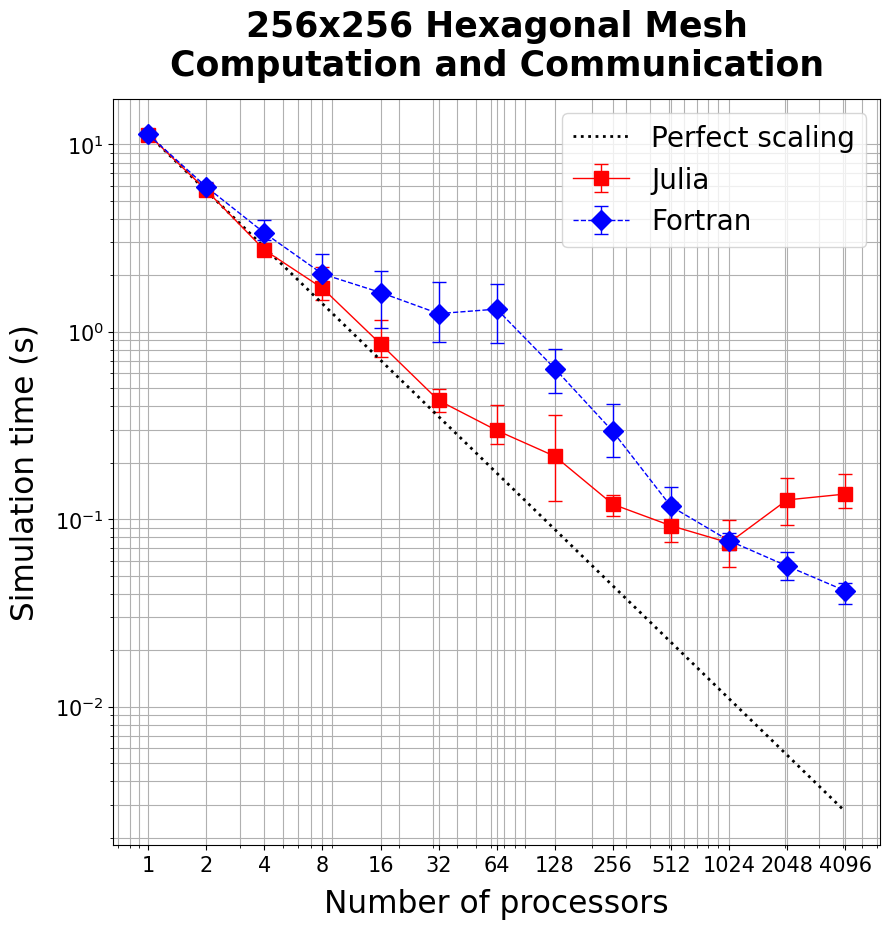

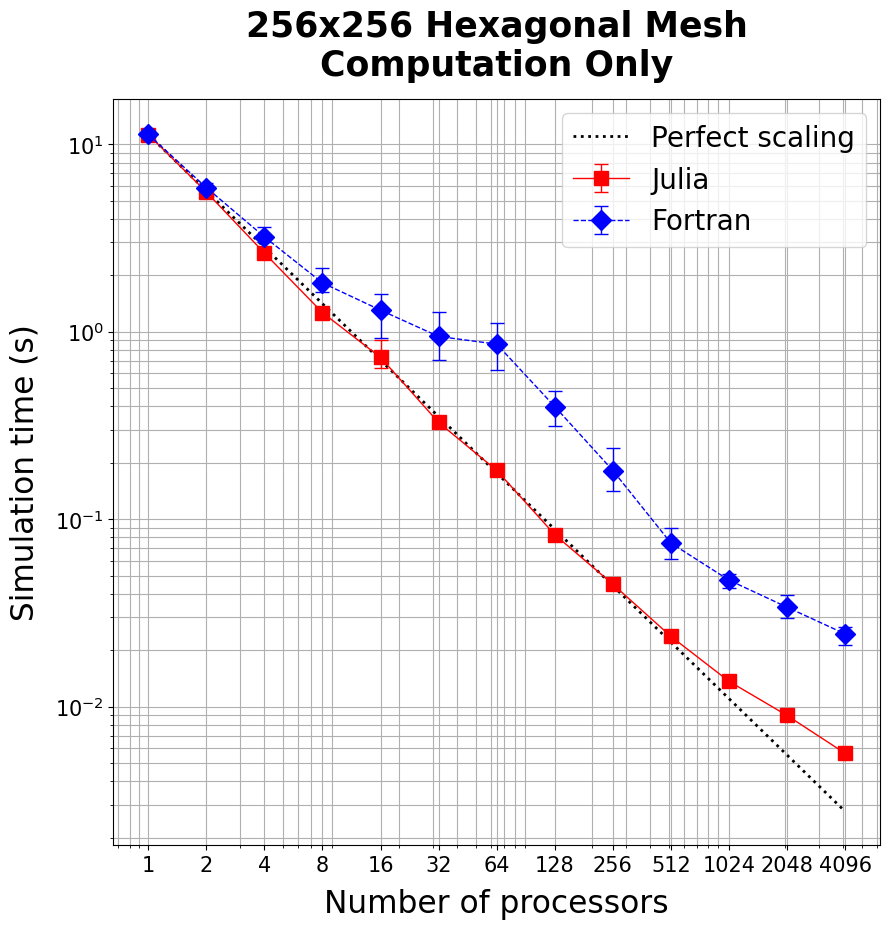

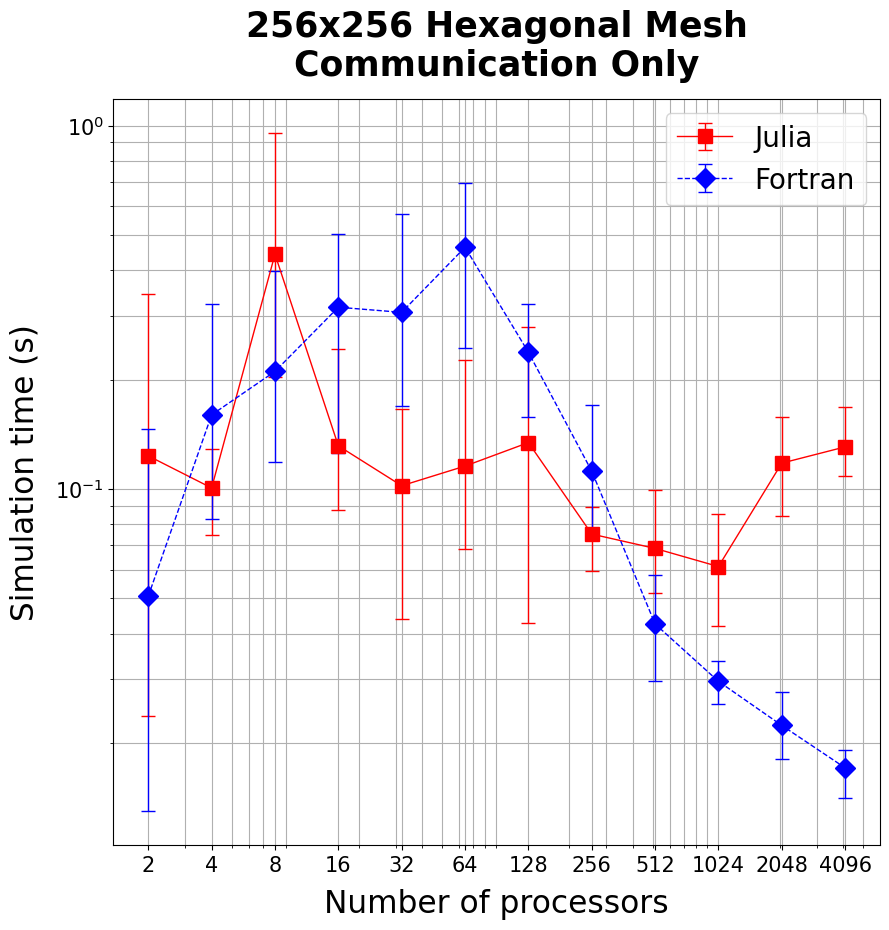

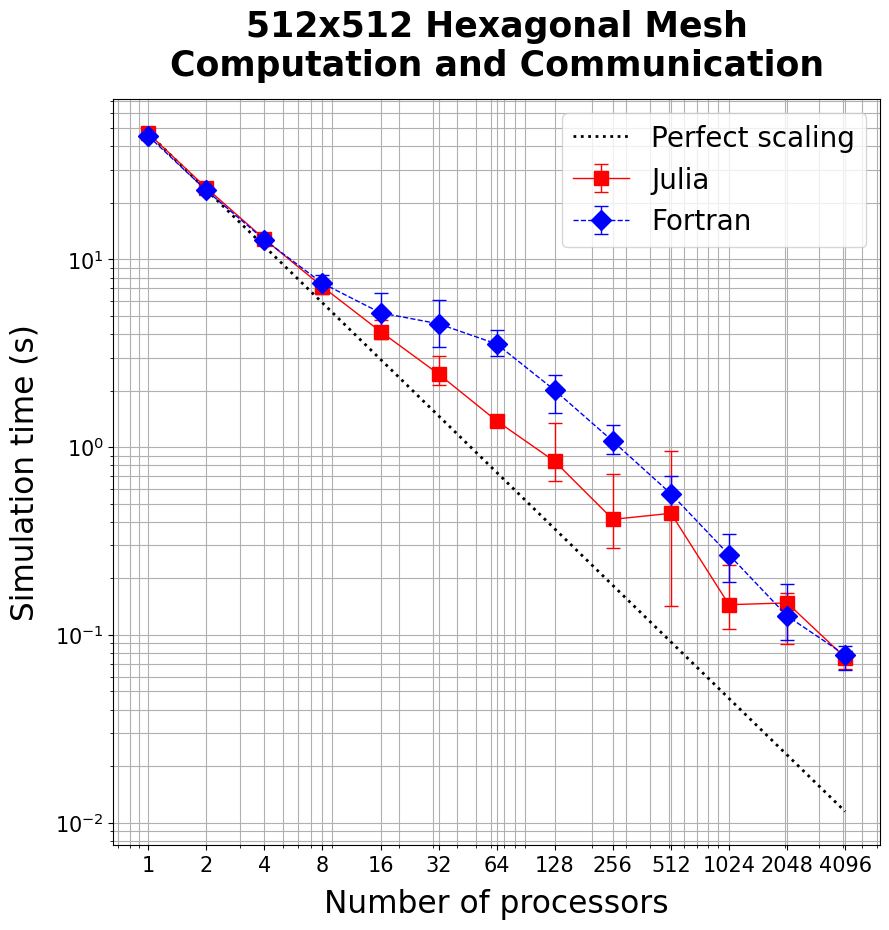

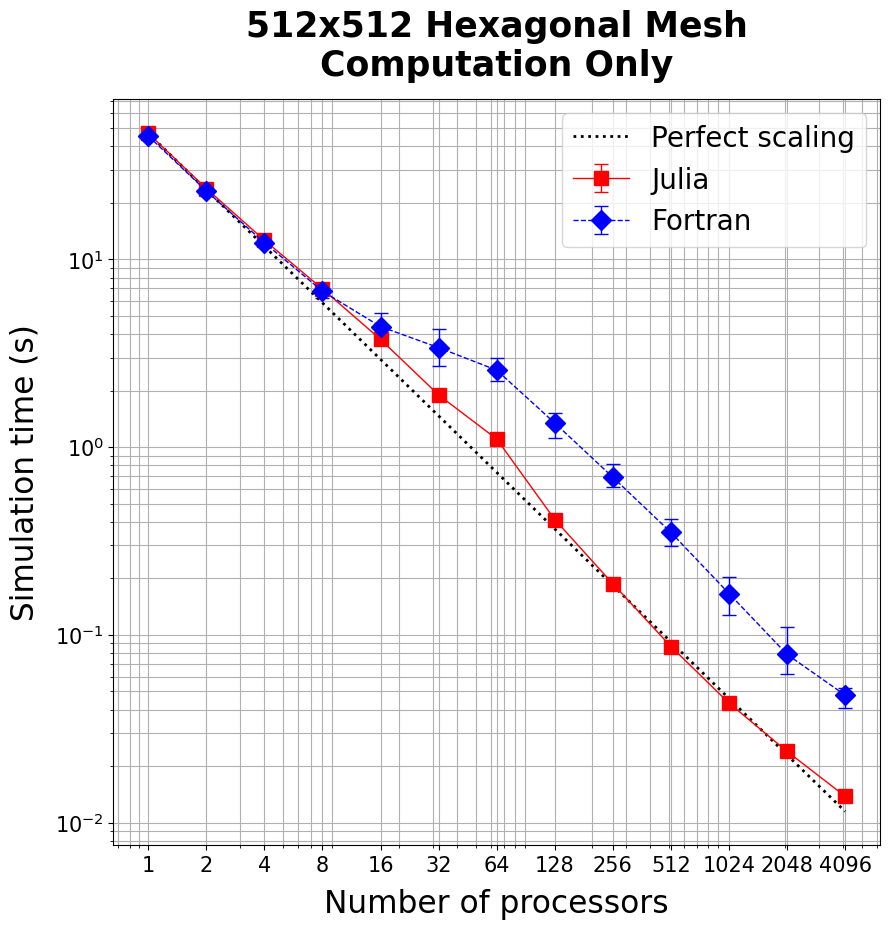

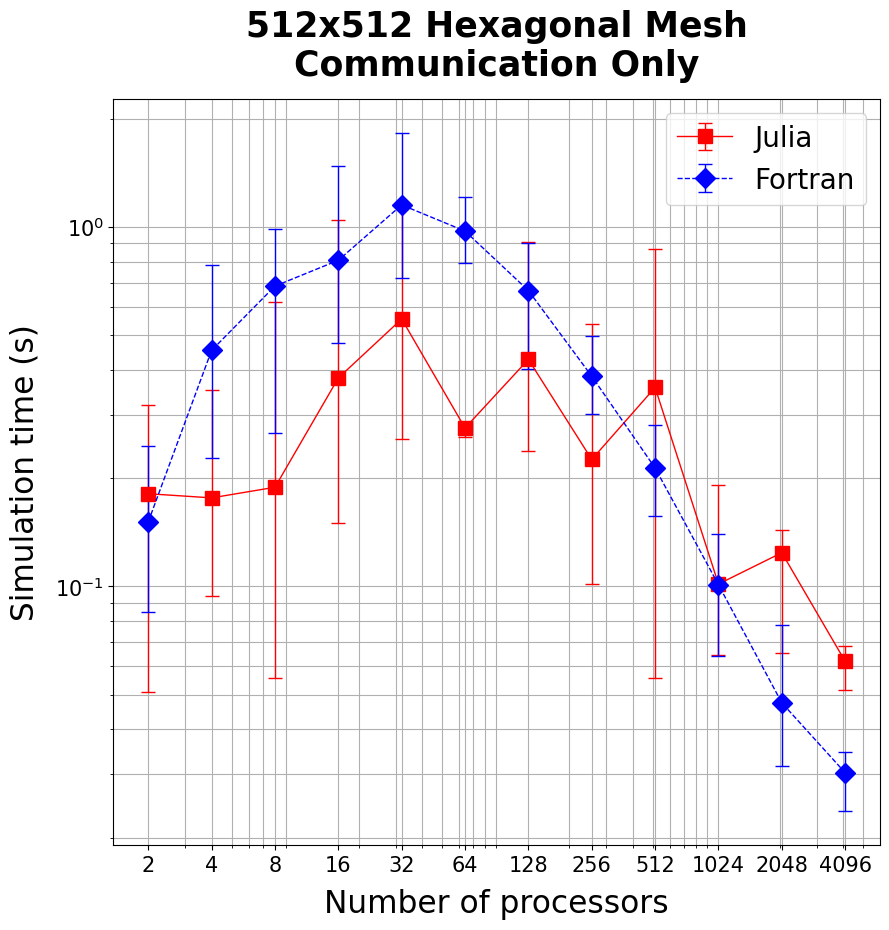

In [62]:
for nCellsX in [128, 256, 512] # 16, 32, 64, 
    jrun, jmpi, jprocs, jrunminmax, jmpiminmax, jfile = juliatimes(nCellsX, maxprocs[nCellsX])
    frun, fmpi, fprocs, frunminmax, fmpiminmax, ffile = fortrantimes(nCellsX, ftprocs[nCellsX])
    
    # only take the data points they both have
    jmatch = findall(i -> i in fprocs, jprocs)
    fmatch = findall(i -> i in jprocs, fprocs)
    frun, fmpi, fprocs, frunminmax, fmpiminmax = frun[fmatch], fmpi[fmatch], fprocs[fmatch], frunminmax[:,fmatch], fmpiminmax[:,fmatch]
    jrun, jmpi, jprocs, jrunminmax, jmpiminmax = jrun[jmatch], jmpi[jmatch], jprocs[jmatch], jrunminmax[:,jmatch], jmpiminmax[:,jmatch]
    
    fig, ax = strongscalingplot(jrun, jprocs, frun, fprocs, nCellsX,
                        abs.(jrun' .- jrunminmax), abs.(frun' .- frunminmax))
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh\nComputation and Communication", fontsize=titlefontsize, fontweight="bold", y=1.02)
    if savefigs
        savename = replace(jfile[length(CODE_ROOT)+2:end], ("/" => "--"))
        fig.savefig("$(CODE_ROOT)/plots/strong_scaling/total_$(savename).pdf", bbox_inches="tight")
        println("saved at $(CODE_ROOT)/plots/strong_scaling/total_$(savename).pdf")
    end
    
    ## gpu
    # gpufname = latestfile(CODE_ROOT *  "/output/inertiagravitywave/NVIDIA A100-SXM4-40GB/resolution$(nCellsX)x$(nCellsX)/steps10/nvlevels100/", x -> x[end-3:end] == ".txt")
    # gputimes = readdlm(gpufname)
    # simtimes = gputimes[1,:]
    # bustimes = gputimes[2,:]
    # meangpu = mean(simtimes[2:end])
    # meangpucom = mean(bustimes[2:end])
    # plt.axhline(y=meangpu, color="g")
    # plt.axhline(y=meangpucom, color="g", linestyle="--")

    
    fig1, ax1 = strongscalingplot(jrun - jmpi, jprocs, frun - fmpi, fprocs, nCellsX,
                            abs.((jrun' - jmpi') .- (jrunminmax .- jmpiminmax)), abs.((frun' - fmpi') .- (frunminmax .- fmpiminmax)))
    ax1.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh\nComputation Only", fontsize=titlefontsize, fontweight="bold", y=1.02)
    
    # exclude communication time at 1 process, this is meaningless
    jcut1 = findall(p -> p != 1, jprocs)
    fcut1 = findall(p -> p != 1, fprocs)
    fig2, ax2 = strongscalingplot(jmpi[jcut1], jprocs[jcut1], fmpi[fcut1], fprocs[fcut1], nCellsX, 
                            abs.(jmpi' .- jmpiminmax)[:,jcut1], abs.(fmpi' .- fmpiminmax)[:,fcut1], perfect=false)
    ax2.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh\nCommunication Only", fontsize=titlefontsize, fontweight="bold", y=1.02)
    
    # fig, ax = strongscalingplot2(jrun .- jmpi, jrunminmax, jmpi, jmpiminmax, jprocs, frun .- fmpi, frunminmax, fmpi, fmpiminmax, fprocs, nCellsX)
    
    if savefigs
        savename = replace(jfile[length(CODE_ROOT)+2:end], ("/" => "--"))
        fig1.savefig("$(CODE_ROOT)/plots/strong_scaling/calc_only_$(savename).pdf", bbox_inches="tight")
        fig2.savefig("$(CODE_ROOT)/plots/strong_scaling/comm_only_$(savename).pdf", bbox_inches="tight")
        println("saved at $(CODE_ROOT)/plots/strong_scaling/calc_only_$(savename).pdf")
    end
    
    println(jfile[end-60:end])
    println(ffile[end-60:end])
end

In [109]:
function timesplitplot(nprocs, comptime, mpitime, nCellsX, info="")
    fontscale = 2
    
    fig, ax = plt.subplots(1,1, figsize=(length(comptime)*3,8))
#     df = DataFrame(processors=nprocs, computation=comptime, communication=mpitime)
#     df.plot(kind="bar", 
#             stacked=true, 
#             colormap="tab10", 
#             figsize=(10, 6))
    totals = comptime + mpitime
    
    ax.bar(string.(Int.(nprocs)), comptime ./ totals, color="blue", label="Computation")
    ax.bar(string.(Int.(nprocs)), mpitime ./ totals, bottom=comptime ./ totals, color="red", label="Communication")
    
    ax.legend(loc="center left", fontsize=20*fontscale, bbox_to_anchor=(1,0.5))
    
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlabel("Number of processors", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.set_ylabel("Proportion of time", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.tick_params(axis="x", labelsize=20*fontscale)
    ax.tick_params(axis="y", labelsize=20*fontscale)
    
    # " using $(nCellsX)x$(nCellsX) Hexagonal Mesh"
    ax.set_title("$info: Proportion of Simulation Time \nSpent on Computation and Communication", fontweight="bold", fontsize=30*fontscale, y=1.08)
    
#     plt.tick_params(top="off", bottom="off", left="off", right="off", labelleft="off", labelbottom="on")
    
    # plt.tight_layout()
    
    return fig, ax
end

timesplitplot (generic function with 2 methods)

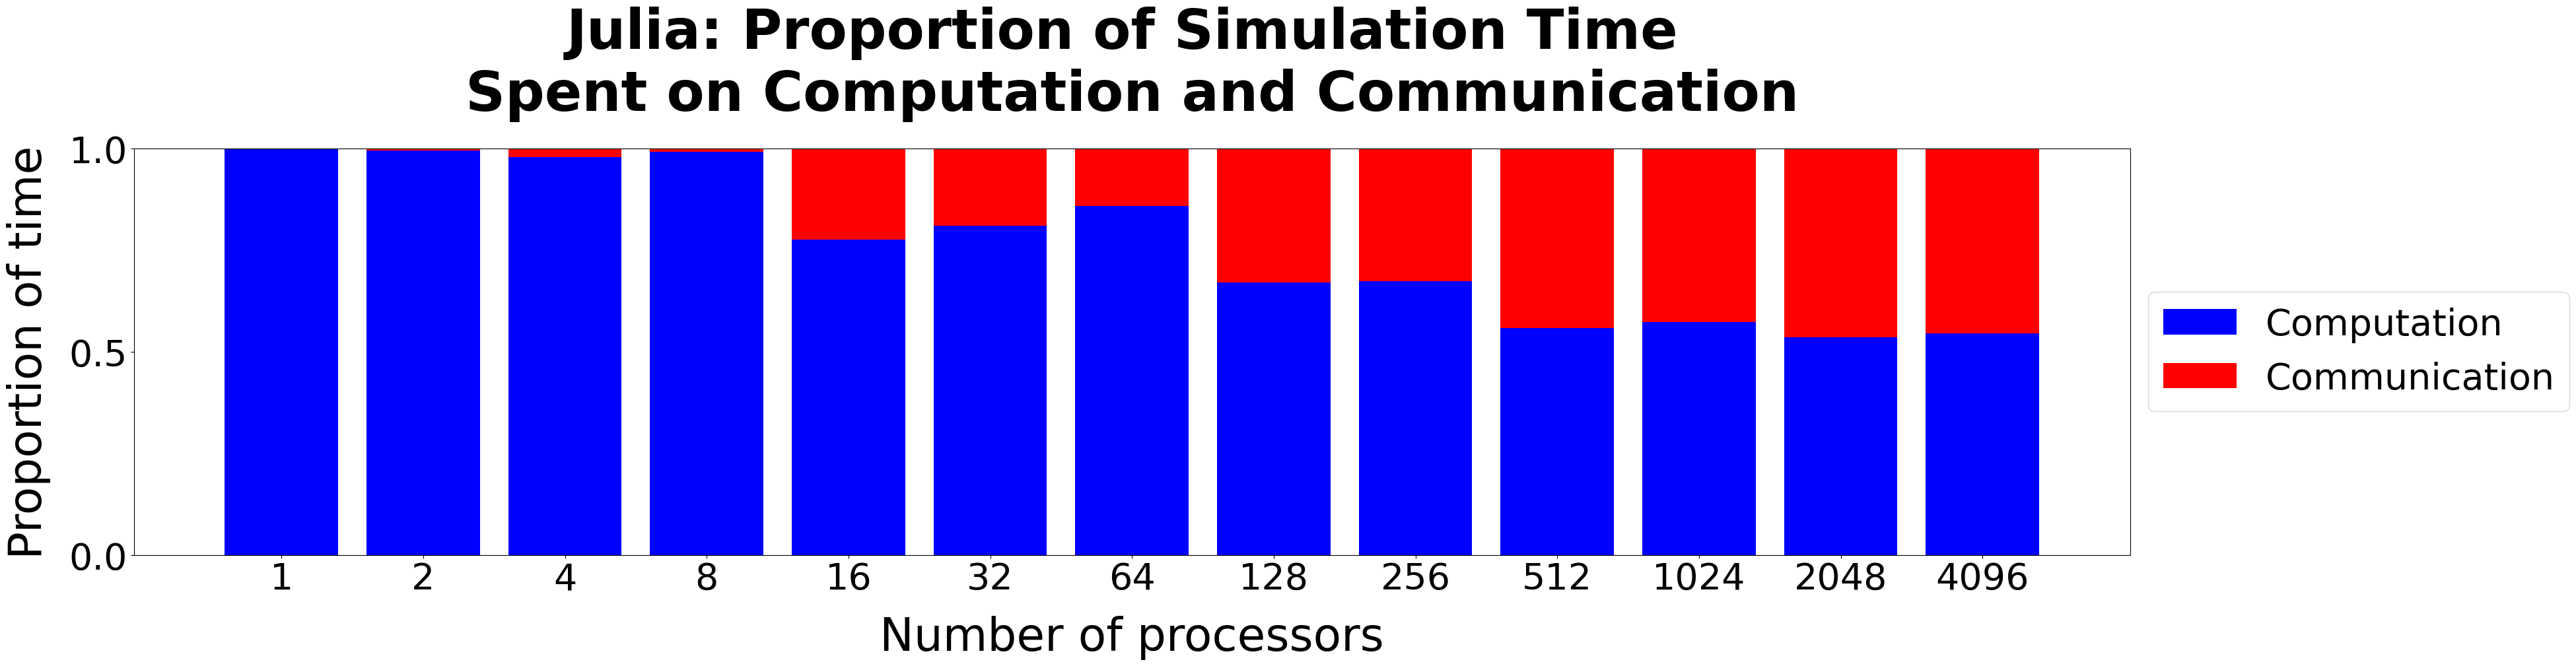

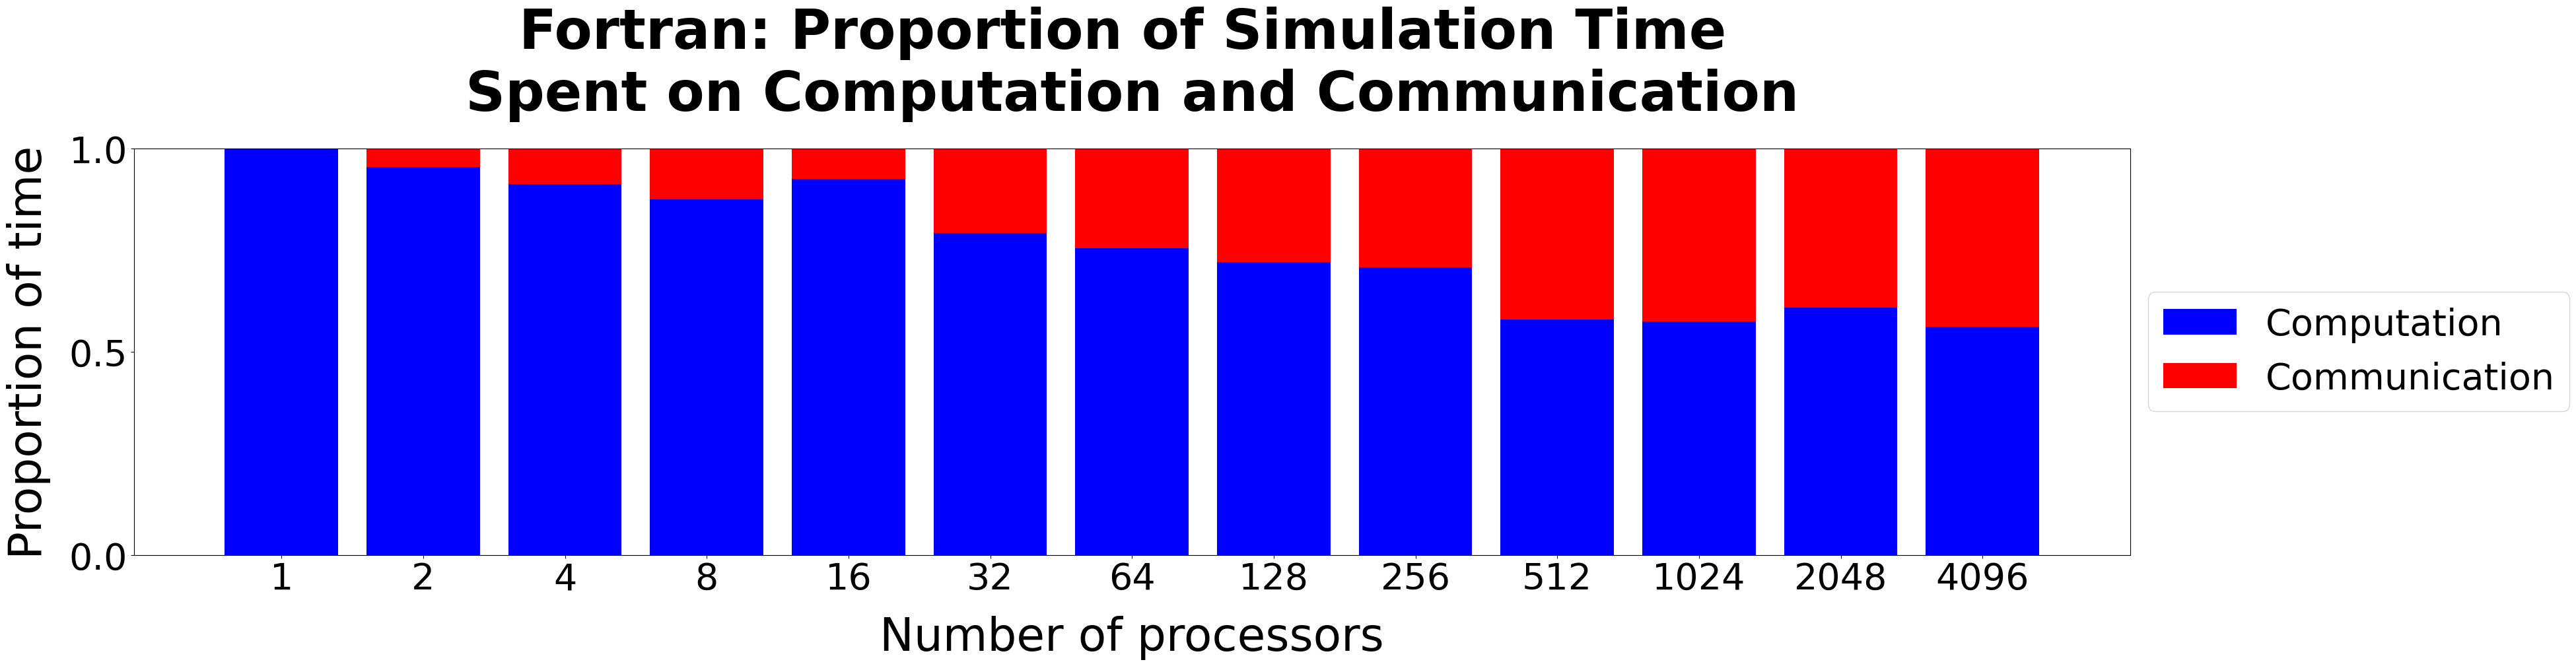

In [111]:
nCellsX = 512
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimminmax, juliampiminmax = juliafortrantimesplits(nCellsX)

fig1, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
fig2, ax = timesplitplot(fortranprocs[end:-1:1], fortransim[end:-1:1], fortranmpi[end:-1:1], nCellsX, "Fortran")

if savefigs
    savenamejl = replace(juliafname[length(CODE_ROOT)+2:end], ("/" => "--"))
    savenameft = replace(fortranfname[length(CODE_ROOT)+2:end], ("/" => "--"))
    fig1.savefig("$(CODE_ROOT)/plots/time_proportion/julia_$(savenamejl).pdf", bbox_inches="tight")
    # fig1.savefig("$(juliafname)_proportion_sim_mpi.pdf", bbox_inches="tight")
    fig2.savefig("$(CODE_ROOT)/plots/time_proportion/fortran_$(savenameft).pdf", bbox_inches="tight")
end

In [51]:
function weakscalingplot(;which="total", resolutions = [16, 32, 64, 128, 256, 512], constlines = [64], mode="weak_scaling", gpu=false)
    function constline(ncells, procs)
        if mode == "weak_scaling"
            return ncells ./ procs
        elseif mode == "constant_nprocs"
            return procs
        else 
            error("unknown mode")
        end
    end
    
    # if mode == "constant nprocs" && constlines == [64]
    #     global FORTRAN_DATA_ROOT = CODE_ROOT * "/data/fortran-timing/timing64_plane"
    # else
    #     global FORTRAN_DATA_ROOT = CODE_ROOT * "/data/fortran-timing"
    # end
    
    jltimes   = zeros((  length(resolutions),length(constlines)))
    jlminmaxs = zeros((2,length(resolutions),length(constlines)))
    fttimes   = zeros((  length(resolutions),length(constlines)))
    ftminmaxs = zeros((2,length(resolutions),length(constlines)))
    gputimes  = zeros((  length(resolutions),length(constlines)))
    gpuminmaxs= zeros((2,length(resolutions),length(constlines)))
    fnames = Vector{String}(undef, length(resolutions))
    
    for (i, nCellsX) in enumerate(resolutions)
    
        jrun, jmpi, jprocs, jrunminmax, jmpiminmax, fnames[i] = juliatimes(nCellsX, maxprocs[nCellsX])
        ind = []
        for con in constlines
            ind = vcat(ind, findall(x->x==con, constline(nCellsX^2, jprocs)))
        end
        
        if which == "total"
            jltimes[i,:] = jrun[ind]
            jlminmaxs[:,i,:] = jrunminmax[:,ind]
        elseif which == "mpi"
            jltimes[i,:] = jmpi[ind]
            jlminmaxs[:,i,:] = jrunminmax[:,ind]
        elseif which == "comp"
            jltimes[i,:] = jrun[ind] - jmpi[ind]
            jlminmaxs[:,i,:] = jrunminmax[:,ind] - jmpiminmax[:,ind]
        end
        
        if mode == "constant nprocs" && constlines == [64]
            if nCellsX == 512
                frun, fmpi, fprocs, frunminmax, _, _ = fortrantimes(nCellsX, 4096)
            else
                frun, fmpi, fprocs, frunminmax, _, _ = fortrantimes(nCellsX, 64)
            end
        else
            frun, fmpi, fprocs, frunminmax, fmpiminmax, _ = fortrantimes(nCellsX, ftprocs[nCellsX])
        end
        ind = []
        for con in constlines
            ind = vcat(ind, findall(x->x==con, constline(nCellsX^2, fprocs)))
        end
        
        if which == "total"
            fttimes[i,:] = frun[ind]
            ftminmaxs[:,i,:]  = frunminmax[:,ind]
        elseif which == "mpi"
            fttimes[i,:] = fmpi[ind]
            ftminmaxs[:,i,:]  = fmpiminmax[:,ind]
        elseif which == "comp"
            fttimes[i,:] = frun[ind] - fmpi[ind]
            ftminmaxs[:,i,:] = frunminmax[:,ind] - fmpiminmax[:,ind]
        end
        
        if gpu
            gpufname = latestfile(CODE_ROOT *  "/output/inertiagravitywave/NVIDIA A100-SXM4-40GB/resolution$(nCellsX)x$(nCellsX)/steps10/nvlevels100/", x -> x[end-3:end] == ".txt")
            gputtimes = readdlm(gpufname)
            simtimes = gputtimes[1,:]
            bustimes = gputtimes[2,:]
            if which == "total"
                times = simtimes[2:end] + bustimes[2:end]
            elseif which == "mpi"
                times = bustimes[2:end]
            elseif which == "comp"
                times = simtimes[2:end]
            end
            gpuminmaxs[:,i,:] = vcat(minimum(times), maximum(times))
            gputimes[i,:] .= mean(times)
        end
        
    end
    
    # plot
    println(fnames)
    for (i, con) in enumerate(constlines)
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylabel("Simulation time (s)", fontsize=labelfontsize, labelpad=10)
        
        if which == "total"
            whichname = "Computation and Communication"
        elseif which == "mpi"
            whichname = "Communication Only"
        elseif which == "comp"
            whichname = "Computation Only"
        end
        if mode == "weak_scaling"
            ax.set_title("Weak Scaling: $(con) Cells/Process\n$(whichname)", fontsize=titlefontsize, fontweight="bold", y=1.02)
            ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
            xaxis = Int.(resolutions .^ 2 / con) # = num proccessors
            xlabels = xaxis
        elseif mode == "constant_nprocs"
            ax.set_title("$(con) MPI Processes versus 1 GPU\n$(whichname)", fontsize=titlefontsize, fontweight="bold", y=1.02)
            ax.set_xlabel("Mesh size", fontsize=labelfontsize, labelpad=10)
            xaxis = resolutions .^ 2 # mesh size
            xlabels = string.(resolutions) .* "x" .* string.(resolutions)
        end
        
        julialines = ax.errorbar(xaxis, jltimes[:,i], yerr=abs.(jltimes[:,i]' .-jlminmaxs[:,:,i]), label="Julia MPI", 
                        capsize=5, linewidth=linewidth, linestyle="-", marker="s", markersize=markersize, color=red)
        fortranlines = ax.errorbar(xaxis, fttimes[:,i], yerr=abs.(fttimes[:,i]' .-ftminmaxs[:,:,i]), label="Fortran MPI",
                        capsize=5, linewidth=linewidth, linestyle="--", marker="D", markersize=markersize, color=blue)
        if gpu
            gpuline = ax.errorbar(xaxis, gputimes[:,i], yerr=abs.(gputimes[:,i]' .- gpuminmaxs[:,:,i]), label="Julia GPU",
                        capsize=5, linewidth=linewidth, linestyle=":", marker="o", markersize=markersize, color="green")
        end
        
        low = minimum(vcat(jltimes[:,i], fttimes[:,i]))
        high = maximum(vcat(jltimes[:,i], fttimes[:,i]))
        if gpu
            low = minimum(vcat(low, gputimes))
            high = maximum(vcat(high, gputimes))
        end
        ax.set_ylim(low/4+1e-9, high*4)
        ax.set_xticks(xaxis)
        ax.tick_params(axis="x", labelsize=tickfontsize)
        ax.tick_params(axis="y", labelsize=tickfontsize)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.set_xticklabels(xlabels)
        # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.legend(loc="upper center", fontsize=labelfontsize-2.5)
        ax.grid(which="both")
        plt.tight_layout()
        
        if mode == "weak_scaling" && which == "mpi" && xaxis[1] == 1
            # clip out single-processor communication time as this is meaningless
            julialines[1].set_data(xaxis[2:end], jltimes[2:end,i])
            fortranlines[1].set_data(xaxis[2:end], fttimes[2:end,i])
            for errorbar in [ julialines[3][1], fortranlines[3][1] ]
                errorbar.set_alpha(vcat(0, [1 for i in 2:length(xaxis)]))
            end
            for cap in (julialines[2]..., fortranlines[2]...)
                capdata = cap.get_data()
                cap.set_data((capdata[1][2:end], capdata[2][2:end]))
            end
            low = minimum(vcat(jltimes[2:end,i], fttimes[1:end-1,i]))
            high = maximum(vcat(jltimes[2:end,i], fttimes[1:end-1,i]))
            if gpu
                low = minimum(vcat(low, gputimes))
                high = maximum(vcat(high, gputimes))
            end
            ax.set_ylim(low/4+1e-9, high*4)
        end
        
        
        if savefigs
            savename = replace(fnames[end][length(CODE_ROOT)+2:end], ("/" => "--"))
            hasgpu = gpu ? "and-gpu_" : ""
            savepath = "$(CODE_ROOT)/plots/$(mode)/$(which)_$(con)_$(hasgpu)$(resolutions[1])x-$(resolutions[end])x_$(savename).pdf"
            fig.savefig(savepath, bbox_inches="tight")
            println("saved at $(savepath)")
        end
    end
end

weakscalingplot (generic function with 1 method)

In [52]:
savefigs=true

true

["/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution16x16/procs64/steps10/nvlevels100/2023-06-25T14:10:34.281.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution32x32/procs128/steps10/nvlevels100/2023-06-25T14:10:38.801.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution64x64/procs512/steps10/nvlevels100/2023-06-25T14:40:13.840.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2023-06-25T17:31:11.463.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution256x256/procs4096/steps10/nvlevels100/2023-06-24T08:37:01.346.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution512x512/procs4096/steps10/nvlevels100/2023-06-24T09:20:31.617.txt"]
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/weak_scaling/total_64_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps10--nvlevel

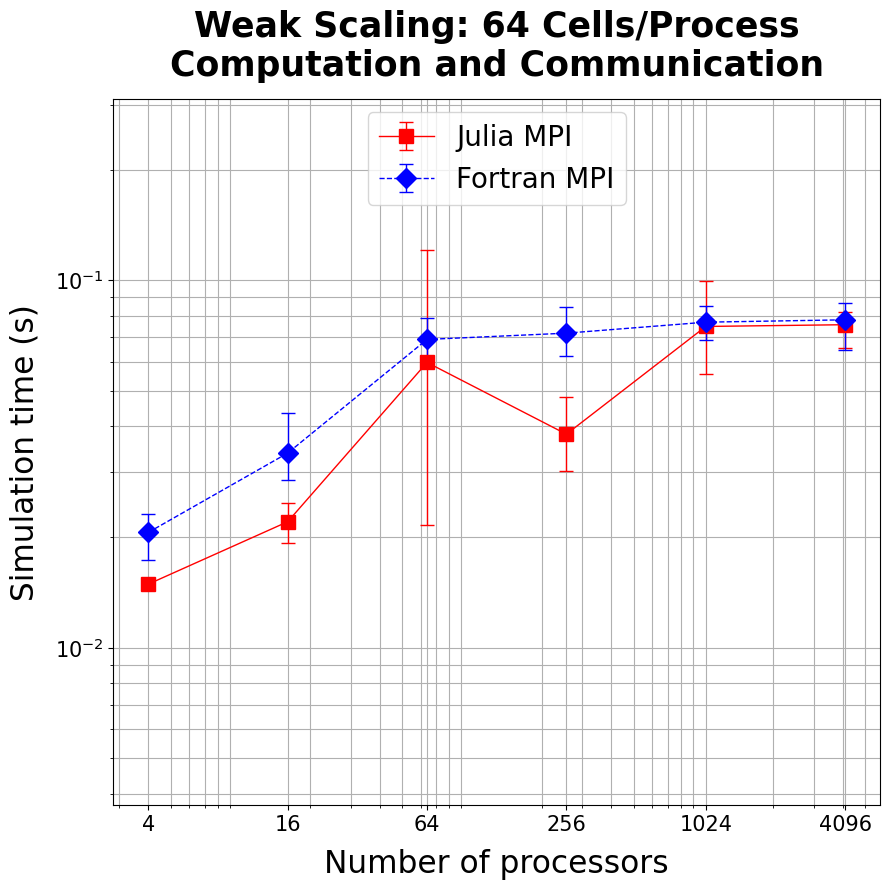

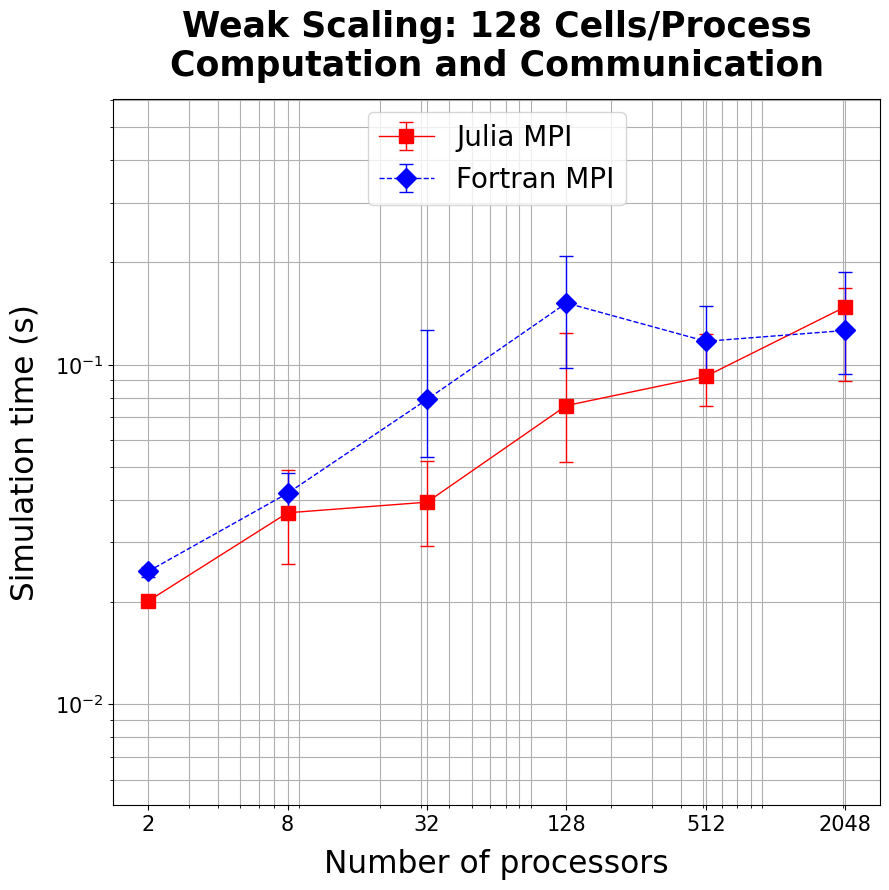

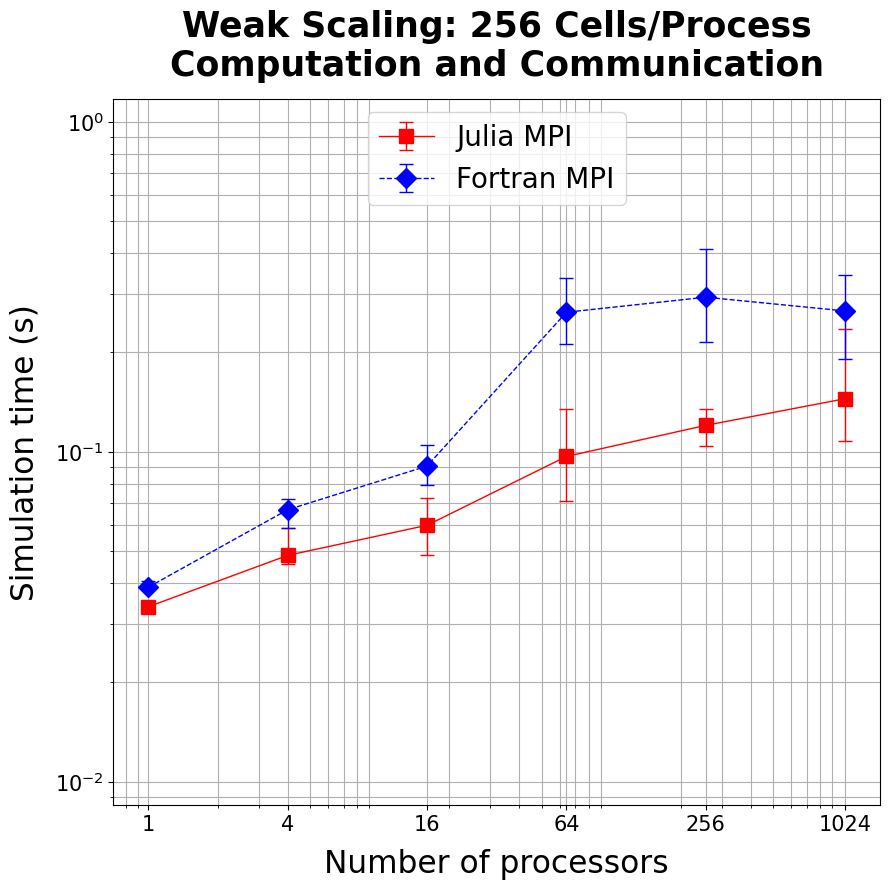

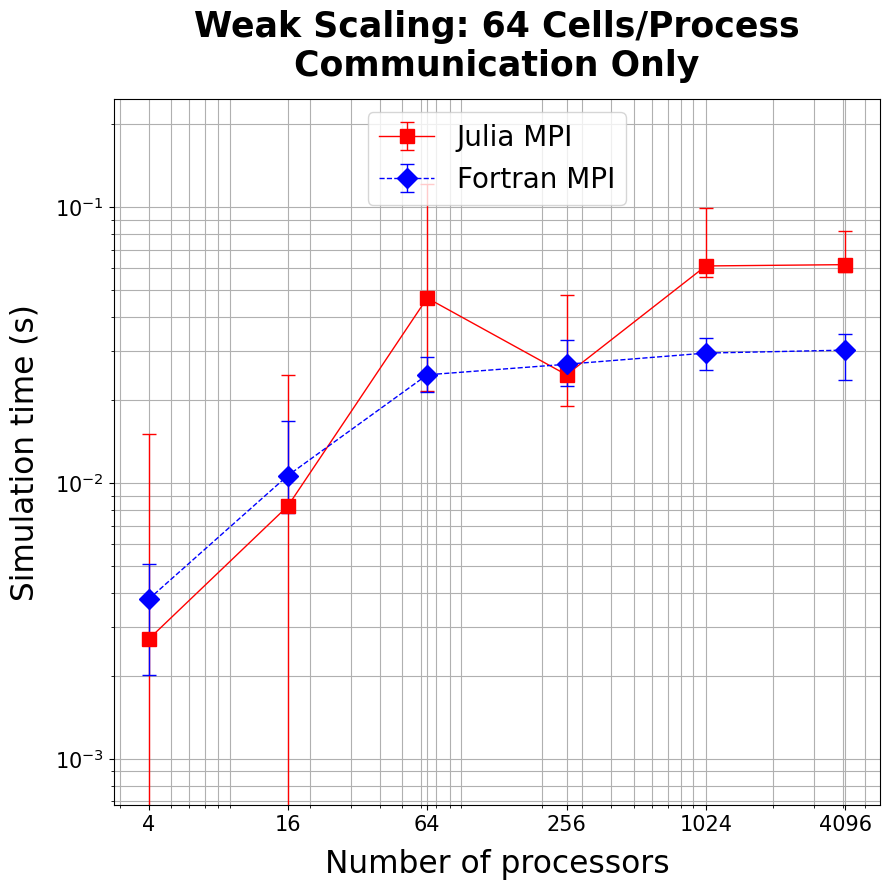

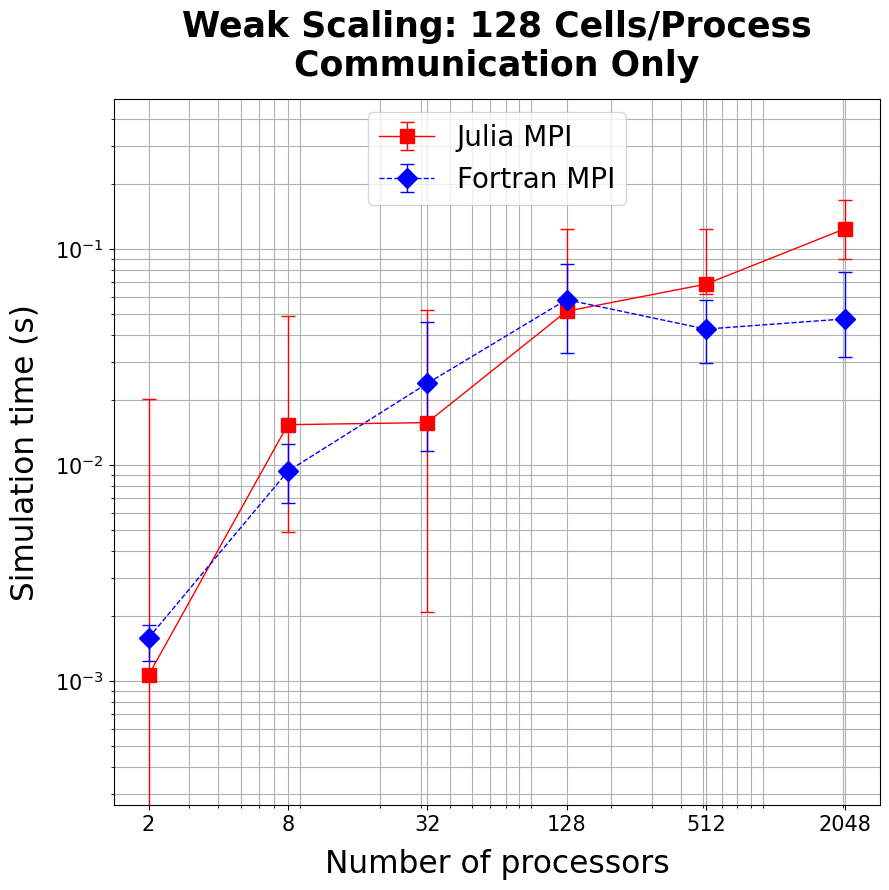

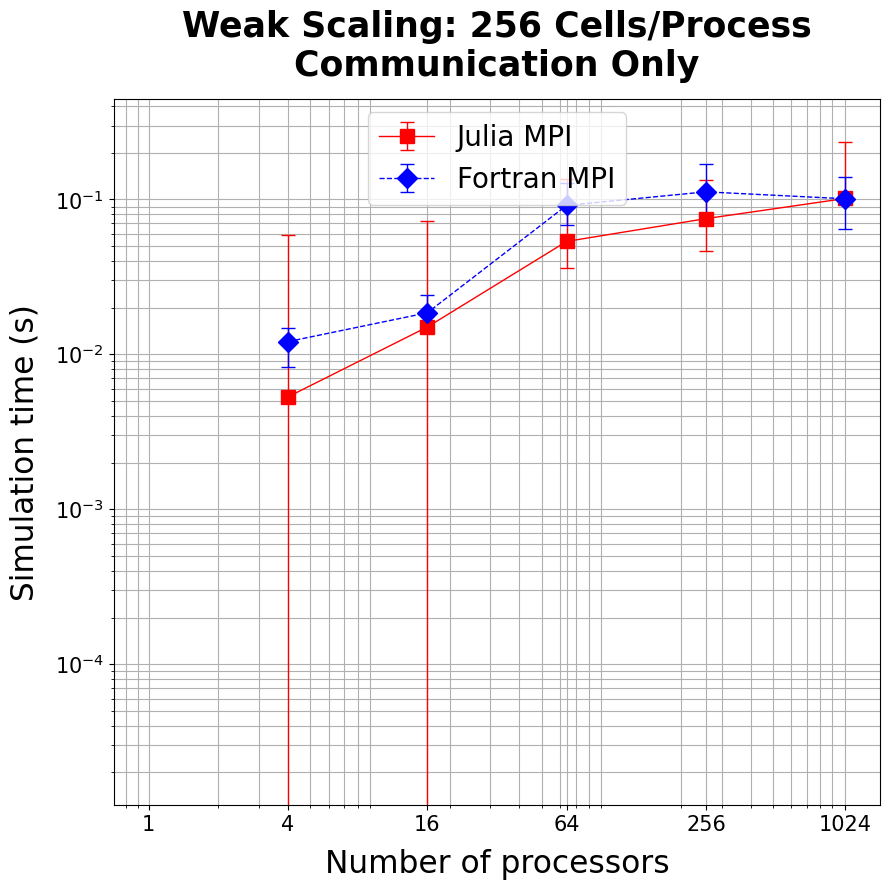

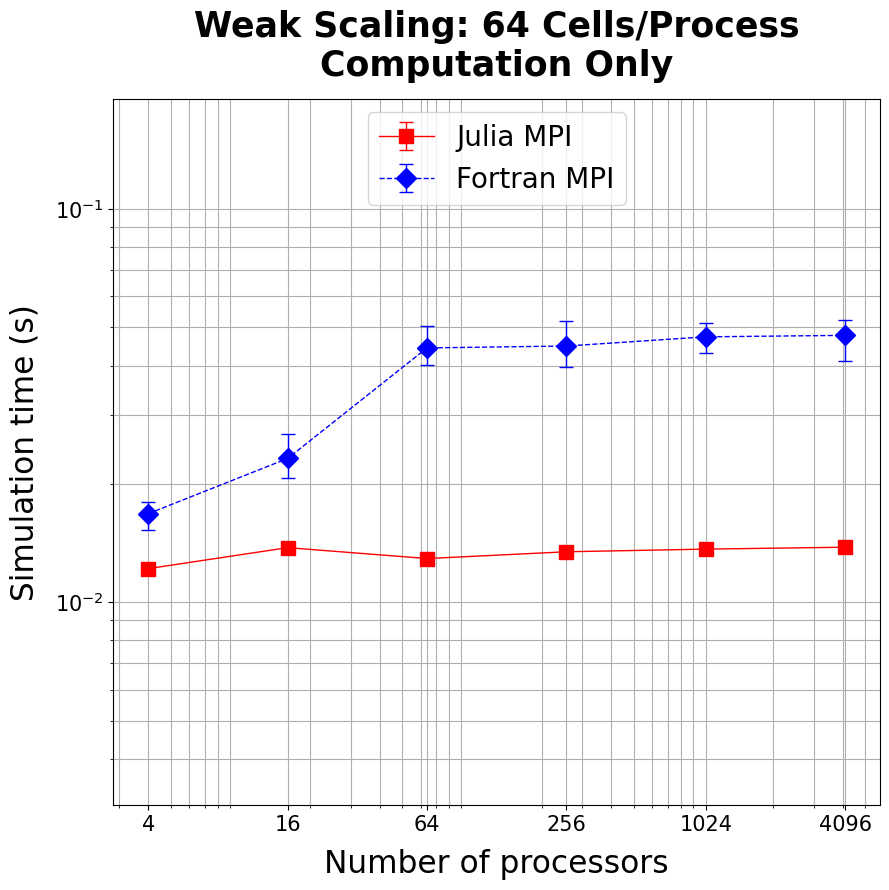

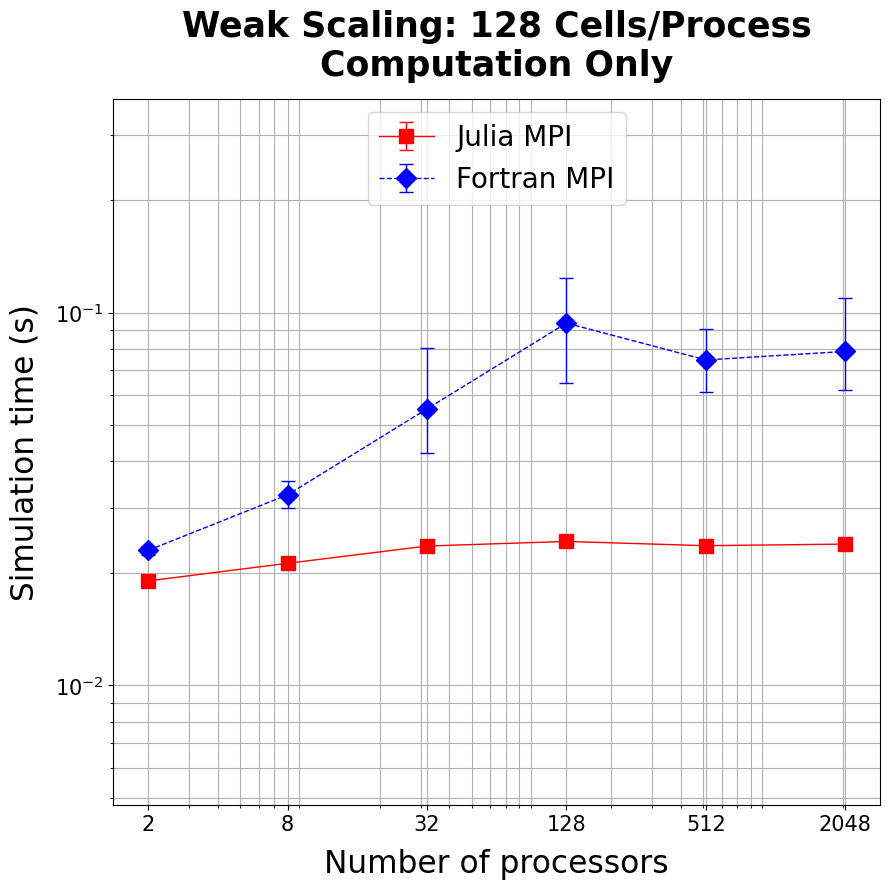

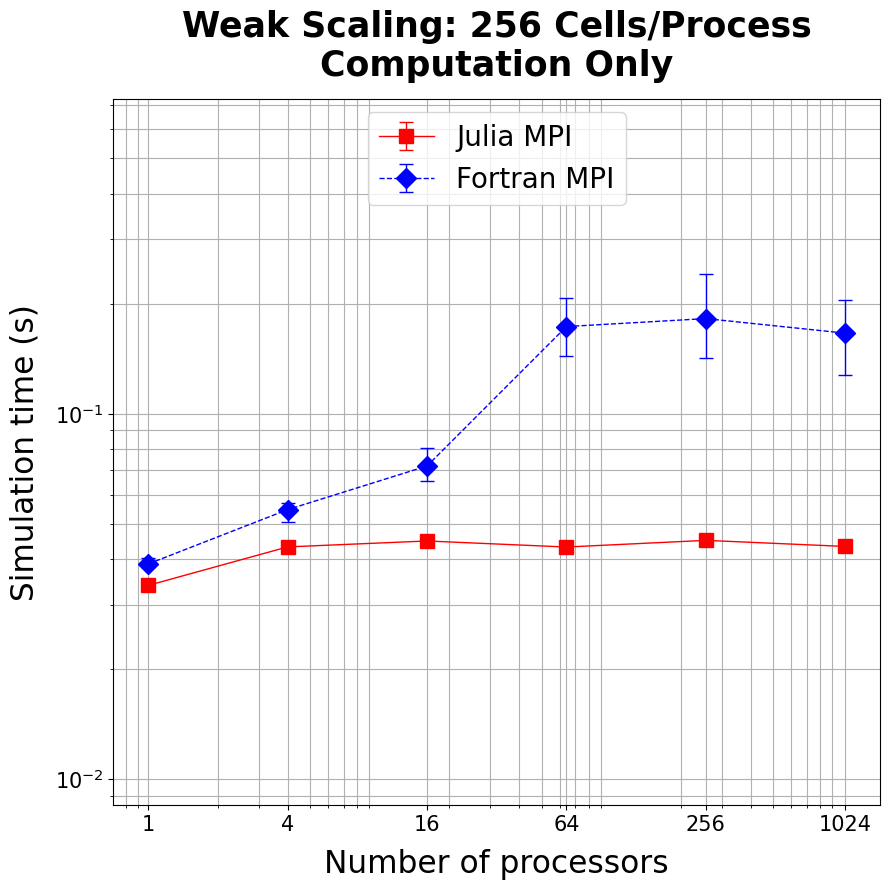

In [53]:
for which in ["total", "mpi", "comp"]
    weakscalingplot(which = which, resolutions = [16, 32, 64, 128, 256, 512], constlines = [64, 128, 256])
end

["/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution16x16/procs64/steps10/nvlevels100/2023-06-25T14:10:34.281.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution32x32/procs128/steps10/nvlevels100/2023-06-25T14:10:38.801.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution64x64/procs512/steps10/nvlevels100/2023-06-25T14:40:13.840.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2023-06-25T17:31:11.463.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution256x256/procs4096/steps10/nvlevels100/2023-06-24T08:37:01.346.txt", "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution512x512/procs4096/steps10/nvlevels100/2023-06-24T09:20:31.617.txt"]
saved at /global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/plots/constant_nprocs/total_64_and-gpu_16x-512x_output--kelvinwave--resolution512x512--procs4096--steps

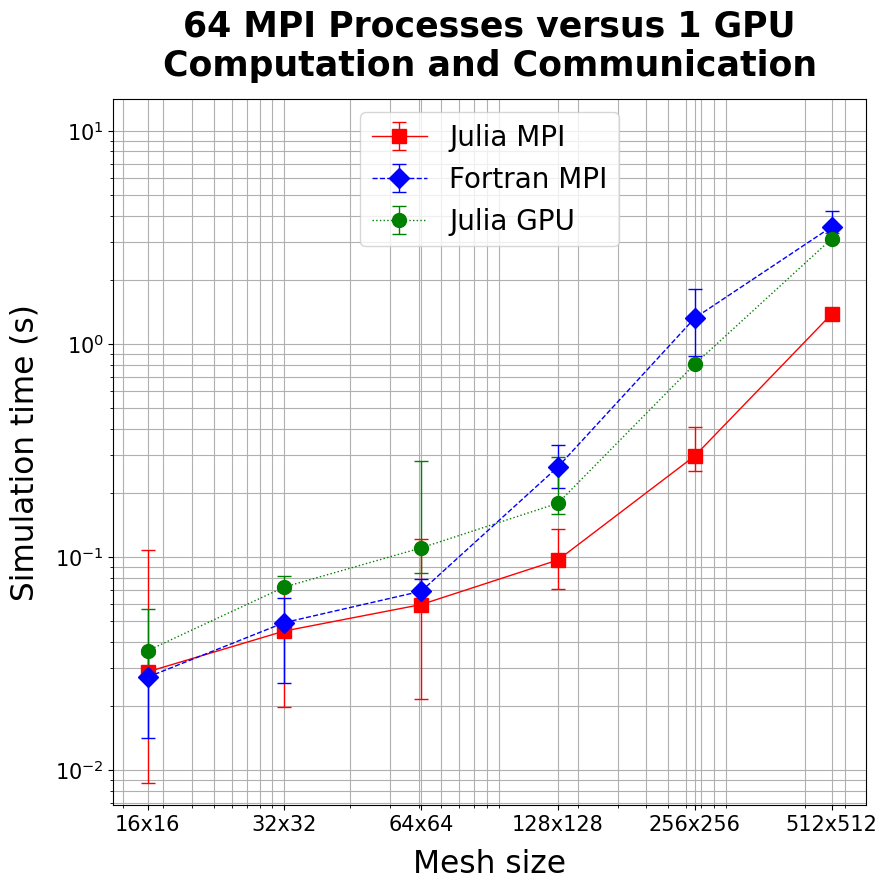

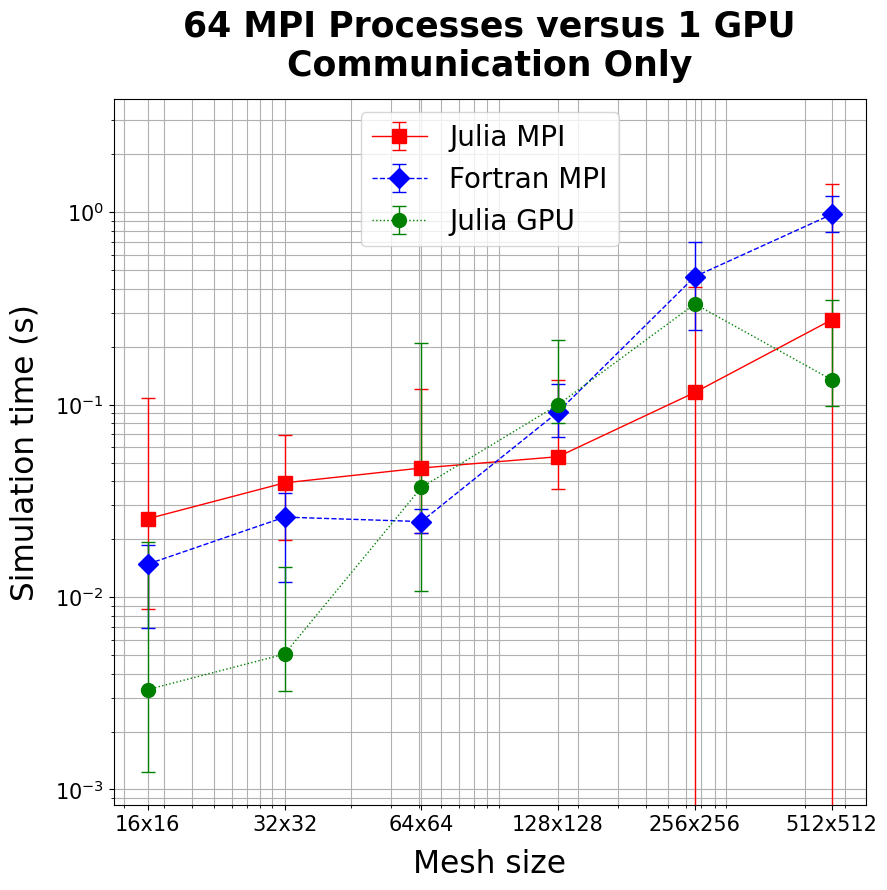

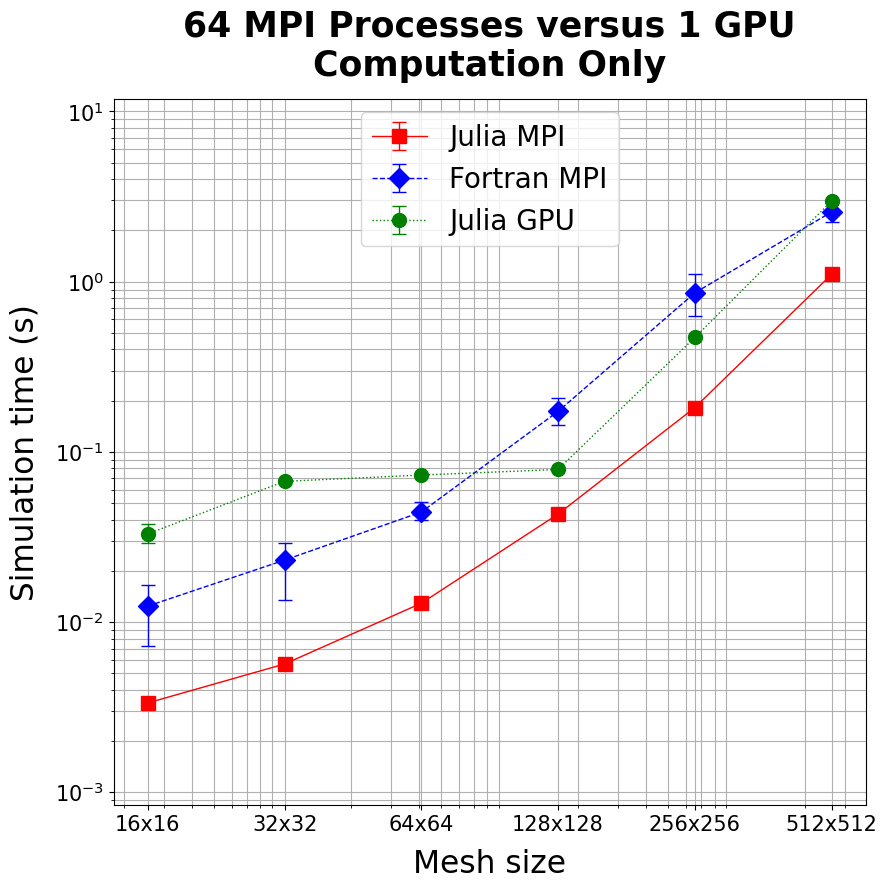

In [56]:
for which in ["total", "mpi", "comp"]
    weakscalingplot(which=which, resolutions = [16, 32, 64, 128, 256, 512], constlines = [64,], mode="constant_nprocs", gpu=true)
end

In [39]:
fortrantimes(32, ftprocs[32])

([0.1566, 0.082891, 0.05461, 0.032463, 0.023214, 0.022338, 0.023154], [0.000103, 0.002356, 0.012089, 0.009353, 0.010641, 0.018337, 0.026021], [1, 2, 4, 8, 16, 32, 64], [0.15577 0.08202 … 0.01713 0.01358; 0.15745 0.0845 … 0.03659 0.02935], [8.0e-5 0.00173 … 0.00945 0.01191; 0.00012 0.00359 … 0.04327 0.03462], "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/data/new-fortran-timing/resolution32x32")

In [229]:
nCellsX = 256
jprocs = 4096
fprocs = 4096
fname = latestfile(JULIA_DATA_ROOT * "/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
df = DataFrame(CSV.File(fname))

runs = filter(col->startswith(col,"sim_time"), names(df))[2:end]
mpis = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
juliasimmean = 1/length(runs) * sum(Array(df[:,runs]), dims=2)
juliampimean = 1/length(mpis) * sum(Array(df[:,mpis]), dims=2)
juliameans = juliasimmean .+ juliampimean


fortranfnamesim = latestfile(FORTRAN_DATA_ROOT, x -> occursin("$fprocs", x) && occursin("$(nCellsX)x$(nCellsX)", x) && x[end-3:end] == ".txt" && occursin("runtime", x))
fortranfnamempi = latestfile(FORTRAN_DATA_ROOT, x -> occursin("$fprocs", x) && occursin("$(nCellsX)x$(nCellsX)", x)  && x[end-3:end] == ".txt" && occursin("halotime", x))
fortransimtiming = readdlm(fortranfnamesim, skipstart=8)
fortranmpitiming = readdlm(fortranfnamempi, skipstart=8)
fortransimmean = fortransimtiming[:,end] #./ 4
fortranmpimean = fortranmpitiming[:,end]
fortransimstd = dropdims( std(Array(fortransimtiming[:,2:end-1]), dims=2), dims=2)
fortranmpistd = dropdims( std(Array(fortranmpitiming[:,2:end-1]), dims=2), dims=2)
fortranprocs = fortransimtiming[:,1]

juliasimstd = std(Array(df[:,runs]), dims=2)
juliampistd = std(Array(df[:,mpis]), dims=2)

df

Row,procs,sim_time1,sim_time2,sim_time3,sim_time4,sim_time5,sim_time6,mpi_time1,mpi_time2,mpi_time3,mpi_time4,mpi_time5,mpi_time6,max_error,l2_error
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,11.3206,11.5749,11.3468,11.3508,11.2838,11.3219,0.0,0.0,0.0,0.0,0.0,0.0,0.000105101,2.35253e-5
2,2.0,5.52077,5.51047,5.5061,5.49189,5.44444,5.82095,2.75031,0.14382,0.111595,0.205846,0.365201,0.143344,0.000105101,3.30386e-5
3,4.0,2.73427,2.65982,2.65328,2.65581,2.65631,2.65959,3.59264,0.135327,0.0824391,0.0673102,0.0909821,0.114359,1.96094e-5,3.78619e-6
4,8.0,1.37598,1.39361,1.39092,1.39195,1.39015,1.39132,2.9108,0.0297822,0.4451,0.0290327,0.096377,0.303973,1.85902e-5,3.80209e-6
5,16.0,0.620092,0.618677,0.620225,0.619541,1.02775,0.607018,3.09266,0.102575,0.129952,0.146766,0.0964225,0.342845,5.13084e-5,1.13302e-5
6,32.0,0.328058,0.340445,0.347881,0.346626,0.347163,0.361922,2.99091,0.279983,0.0683716,0.165692,0.0350969,0.0729889,9.92513e-6,2.66895e-6
7,64.0,0.208361,0.1973,0.195393,0.200074,0.201133,0.200328,3.67747,0.242732,0.0755961,0.105565,0.0869688,0.0991226,1.24943e-5,3.16059e-6
8,128.0,0.0801327,0.0847307,0.0795518,0.0808173,0.0801713,0.0807418,3.07135,0.0304499,0.0295715,0.105542,0.322026,0.209198,0.00013979,4.42071e-5
9,256.0,0.0515061,0.0480749,0.0468511,0.045572,0.0455941,0.0450322,3.31191,0.0867046,0.0764338,0.0553621,0.0621843,0.0577267,0.00011976,3.86438e-5


In [59]:
DataFrame(fortransimtiming[end:-1:1,:], :auto)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,11.6274,11.306,11.2842,11.3394,11.4107,11.3147,11.5528,11.5843,11.6381,11.5997,11.4657
2,2.0,6.43239,6.41896,6.45276,6.48862,6.56703,6.49271,6.34856,6.48092,6.46053,6.43552,6.4578
3,4.0,4.11042,4.10938,4.08829,4.09659,4.09143,4.10853,4.11401,4.09319,4.13801,4.09462,4.10445
4,8.0,3.4052,3.40936,3.42613,3.41951,3.42525,3.41486,3.41174,3.41156,3.43618,3.44581,3.42056
5,16.0,3.1791,3.181,3.17052,3.18835,3.18409,3.21913,3.17429,3.17543,3.1963,3.21514,3.18833
6,32.0,1.61939,1.61937,1.61609,1.62715,1.62151,1.62259,1.62105,1.62223,1.63176,1.62682,1.6228
7,64.0,0.81474,0.81459,0.81148,0.8191,0.8168,0.81495,0.81318,0.81124,0.81402,0.81964,0.814974
8,128.0,0.40364,0.40419,0.40243,0.40151,0.40218,0.40159,0.40348,0.39994,0.40231,0.40292,0.402419
9,256.0,0.17613,0.17894,0.17743,0.17778,0.17845,0.17785,0.17866,0.17599,0.17686,0.17718,0.177527


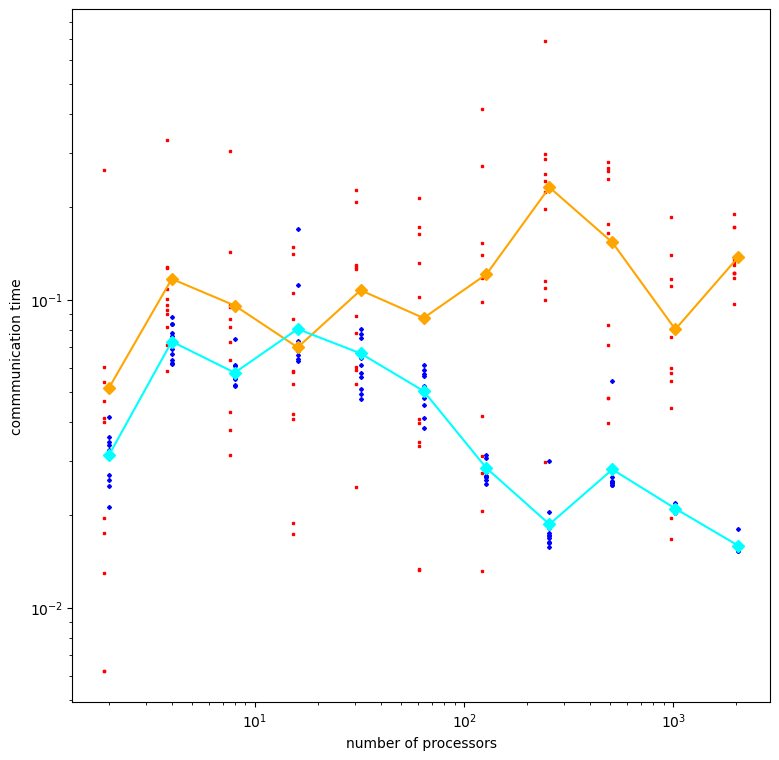

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,9))

ax.set_xscale("log")
ax.set_yscale("log")

for i in 1:length(mpis)
    mpi = mpis[i]
    ax.loglog(df.procs *0.95, df[:,mpi],               marker="s", linestyle="none", color="red",  markersize=2)
    ax.loglog(fortranmpitiming[:,1], fortranmpitiming[:,i+1], marker="D", linestyle="none", color="blue", markersize=2)
end

ax.loglog(df.procs, juliampimean, marker="D", color="orange")
ax.loglog(fortranmpitiming[:,1], fortranmpimean, marker="D", color="cyan")

ax.set_xlabel("number of processors")
ax.set_ylabel("commmunication time")
;

In [227]:
nCellsX = 64
gpufname = latestfile(CODE_ROOT *  "/output/inertiagravitywave/NVIDIA A100-SXM4-40GB/resolution$(nCellsX)x$(nCellsX)/steps10/nvlevels100/", x -> x[end-3:end] == ".txt")
gputtimes = readdlm(gpufname)

2×10 Matrix{Float64}:
 0.0730165   0.0729937   0.0730001   …  0.0729709   0.0729801   0.0729939
 0.00113424  0.00222423  0.00183573     0.00196067  0.00208918  0.00205086

In [235]:
jr, jc, jp, _ = juliatimes(64, 512)

([0.5637772774, 0.3033951758, 0.17816740060000003, 0.09184275540000002, 0.06577800040000001, 0.046091046600000005, 0.049896056999999994, 0.0953471462, 0.07558361220000001, 0.0637460494], [0.0, 0.014847898599999998, 0.0235592846, 0.0147127486, 0.018403604400000002, 0.022230831, 0.03651945620000001, 0.086845613, 0.069220431, 0.0592428608], [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0], [0.556613102 0.293273466 … 0.035061589000000004 0.024428400000000003; 0.580860441 0.341954586 … 0.231271477 0.094620965], [0.0 0.008145549 … 0.028698417 0.019942446000000003; 0.0 0.037995505 … 0.22483556300000002 0.090025179], "/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/resolution64x64/procs512/steps10/nvlevels100/2023-06-17T15:00:48.268.txt")

In [236]:
jr

10-element Vector{Float64}:
 0.5637772774
 0.3033951758
 0.17816740060000003
 0.09184275540000002
 0.06577800040000001
 0.046091046600000005
 0.049896056999999994
 0.0953471462
 0.07558361220000001
 0.0637460494

In [237]:
jp

10-element Vector{Float64}:
   1.0
   2.0
   4.0
   8.0
  16.0
  32.0
  64.0
 128.0
 256.0
 512.0

In [238]:
jc

10-element Vector{Float64}:
 0.0
 0.014847898599999998
 0.0235592846
 0.0147127486
 0.018403604400000002
 0.022230831
 0.03651945620000001
 0.086845613
 0.069220431
 0.0592428608